## Calculating Position based xT

In [1]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

# opening data.
import os
import pathlib
import warnings

# used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening Data

In [2]:
df = pd.DataFrame()
for i in range(13):
    file_name = 'events_England_'+str(i+1)+'.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)

## Actions Moving the ball

To calculate the Expected Threat we need actions that move the ball.
1. We filter them from the database.
2. Remove the passes that ended out of the pitch.
3. Create new columns with coordinates
4. Plot the location of actions moving the ball on 2D histogram. (NOTE: Dribbling is also the action that moves the ball).
5. Not all ground attacking duels are dribblings.
6. Store number of actions in each bin in a `move_count` array to calculate later move probability.

### Moving Events.

| Event | Sub Event | Label              |
|-------|-----------|--------------------|
| 8     | 80        | Cross       |
| 8     | 82        | Head pass   |
| 8     | 83        | High pass   |
| 8     | 84        | Launch      |
| 8     | 85        | Simple pass |
| 8     | 86        | Smart pass  |

In [30]:
next_event = df.shift(-1, fill_value=0)
df['nextEvent'] = next_event['subEventName']

df['kickedOut'] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis=1)

# get move df.
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

# Filtering 'out of the field'.
delete_passes = move_df.loc[move_df['kickedOut'] == 1]
move_df = move_df.drop(delete_passes.index)

# Extract coordinates.
move_df['x'] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105 / 100)
move_df['y'] = move_df.positions.apply(lambda cell: (cell[0]['y']) * 68 / 100)
move_df['end_x'] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105 / 100)
move_df['end_y'] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 105 / 100)
move_df = move_df.loc[(
    ((move_df['end_x'] != 0) & (move_df['end_y'] != 68)) &
    ((move_df['end_x'] != 105) & (move_df['end_y'] != 0))
)]


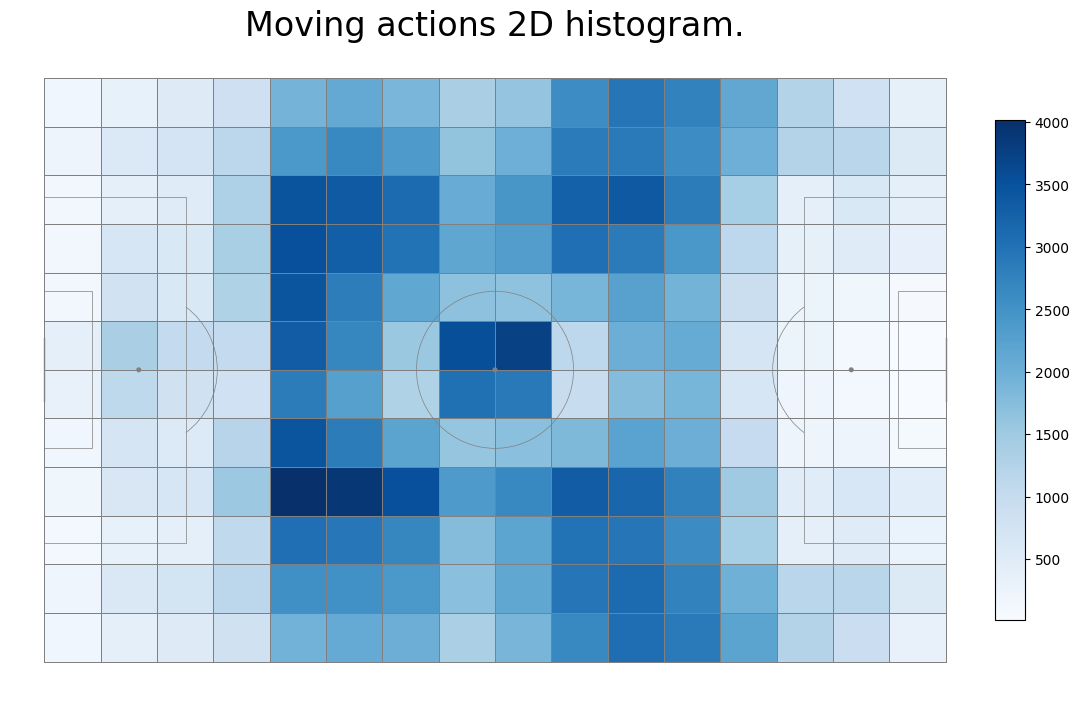

In [86]:
pitch = Pitch(line_color='gray', pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2, linewidth=0.5)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)
pfig, pax = pitch.draw(figsize=(10, 10), tight_layout=True)
pcm = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=pax, linewidth=0.5)
ax_cbar = pfig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)
pax.set_title('Moving actions 2D histogram.', fontsize=24)
plt.show()
move_count = move['statistic']

## Shots

TO calculate Expected Threat we also need shots.
1. Filter them from the database
2. Create new columns with coordinates and plot their location.

10 	100 	Shot – Shot

In [91]:
shots_df = df[df['subEventName'] == "Shot"]
shots_df['x'] = shots_df.positions.apply(lambda cell: (cell[0]['x']) * 105 / 100)
shots_df['y'] = shots_df.positions.apply(lambda cell: (cell[0]['y']) * 68 / 100)
shots_df['end_x'] = shots_df.positions.apply(lambda cell: (cell[1]['x']) * 105 / 100)
shots_df['end_y'] = shots_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68 / 100)

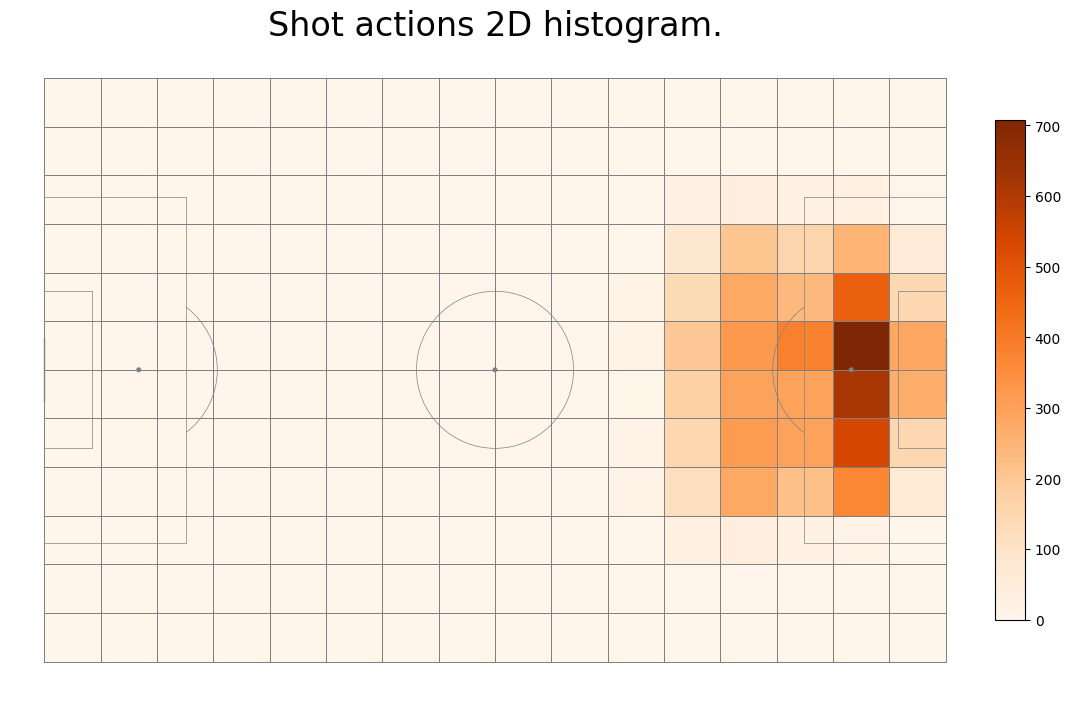

In [95]:
shot = pitch.bin_statistic(shots_df.x, shots_df.y, statistic='count', bins=(16, 12), normalize=False)
shots_count = shot['statistic']
fig, ax = pitch.draw(figsize=(10, 10), tight_layout=True)
pcm = pitch.heatmap(shot, cmap="Oranges", edgecolor="grey", ax=ax, linewidth=0.5)

# ADd legend to plot
ax_cbar = fig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)


ax.set_title('Shot actions 2D histogram.', fontsize=24)
plt.show()

## Goals

To calculatet the Expected Threat we need to filter goals.
1. Filter them from the shots dataframe.
2. Store the number of goal occurances in 2D array.

101 	Goal 	Goal

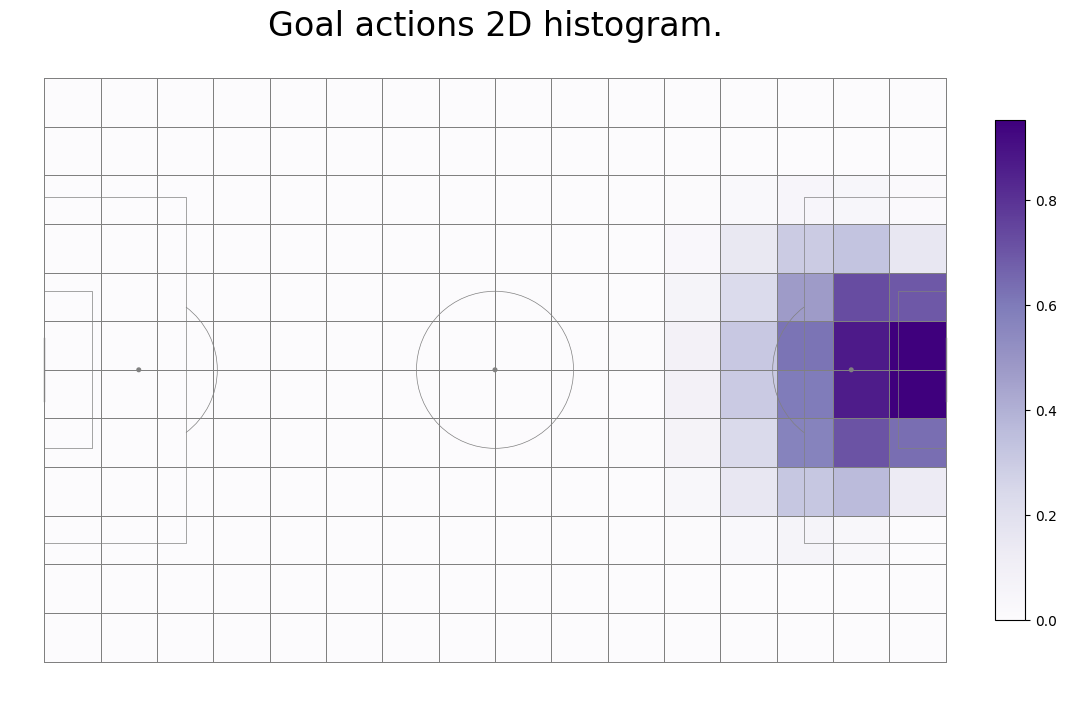

In [118]:
goals_df = shots_df[shots_df.apply(lambda x: {'id': 101} in x.tags, axis=1)]
goals = pitch.bin_statistic(goals_df.x, goals_df.y, statistic='count', bins=(16, 12), normalize=False)
goals_count = goals['statistic']

fig, ax = pitch.draw(figsize=(10, 10), tight_layout=True)
pcm = pitch.heatmap(shot, cmap="Purples", edgecolor="grey", ax=ax, linewidth=0.5)

# ADd legend to plot
ax_cbar = fig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)


ax.set_title('Goal actions 2D histogram.', fontsize=24)
plt.show()

## Move Probability

We now need to calculate the probability of each moving action.
1. We divide its number in each bin by sum of moving actions and shots in that bin.
2. Plot it.

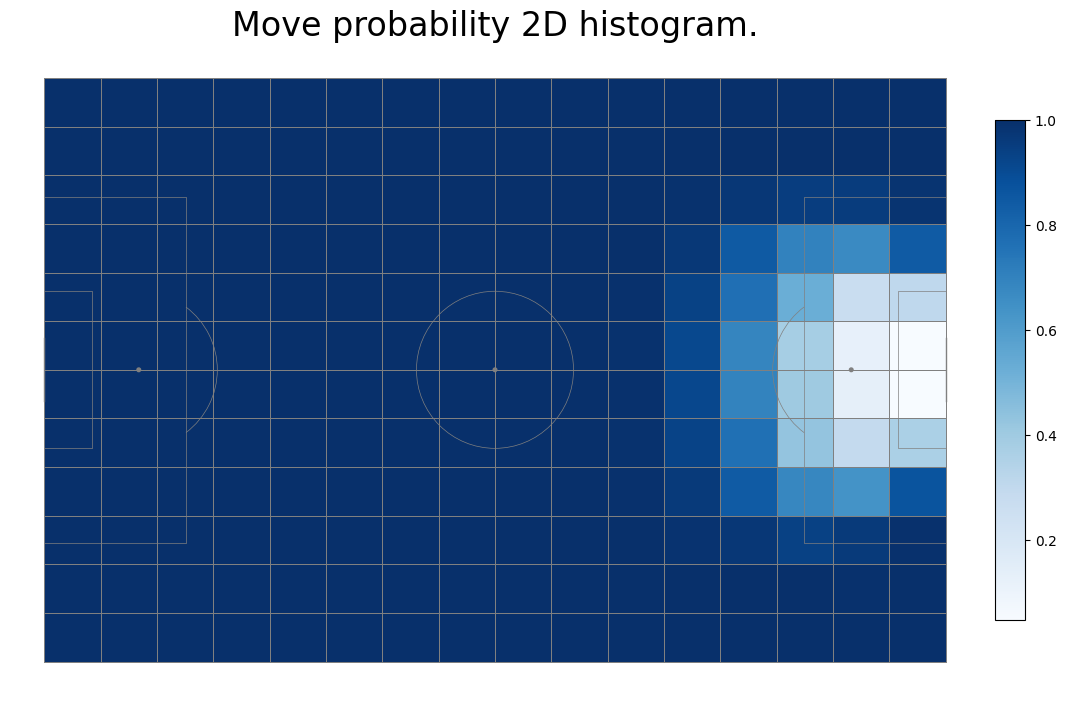

In [113]:
move_probability = move_count / (move_count + shots_count)

# plotting it.
fig, ax = pitch.draw(figsize=(10, 10), tight_layout=True)
move['statistic'] = move_probability
pcm = pitch.heatmap(move, cmap="Blues", edgecolor="grey", ax=ax, linewidth=0.5)

# ADd legend to plot
ax_cbar = fig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)


ax.set_title('Move probability 2D histogram.', fontsize=24)
plt.show()

## Move Probability

We need to calculate probability of a shot in each area.
1. Divide its number in each bin by the sum of moving actions and shots in that bin.
2. plot it.

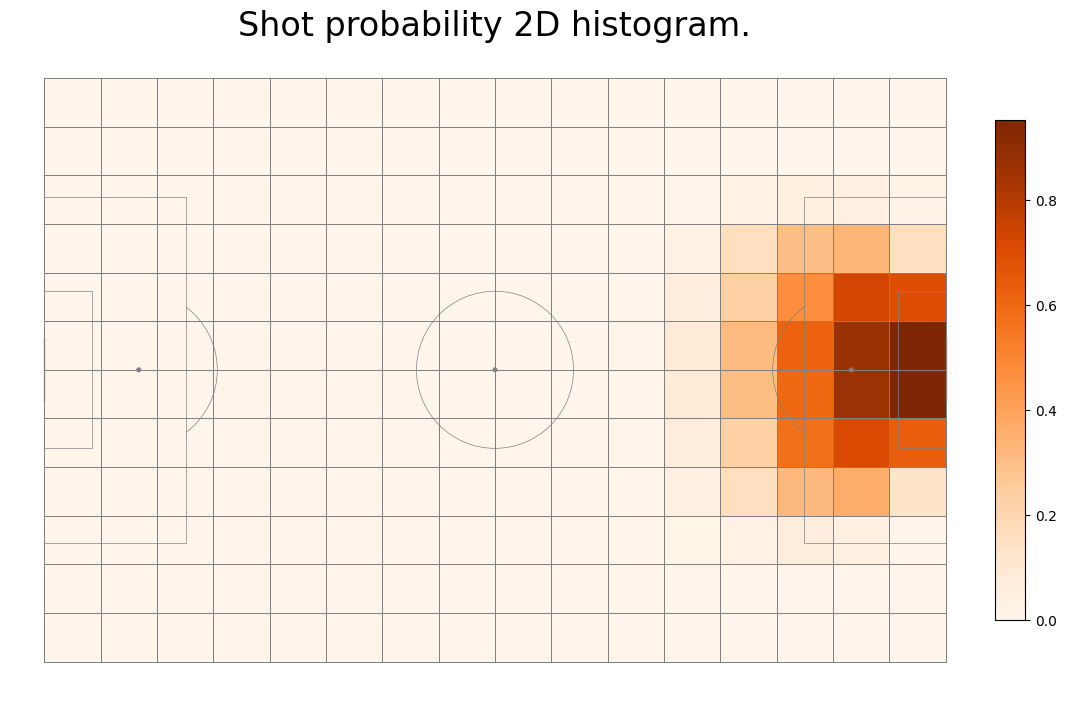

In [115]:
shot_probability = shots_count/(move_count + shots_count)
fig, ax = pitch.draw(figsize=(10, 10), tight_layout=True)
shot['statistic'] = shot_probability

pcm = pitch.heatmap(shot, cmap="Oranges", edgecolor="grey", ax=ax, linewidth=0.5)

# ADd legend to plot
ax_cbar = fig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)


ax.set_title('Shot probability 2D histogram.', fontsize=24)
plt.show()

## Goal Probability

Next thing needed is goal probability.
1. Divide the no of goals in area with the shots taken in area.
2. plot it.

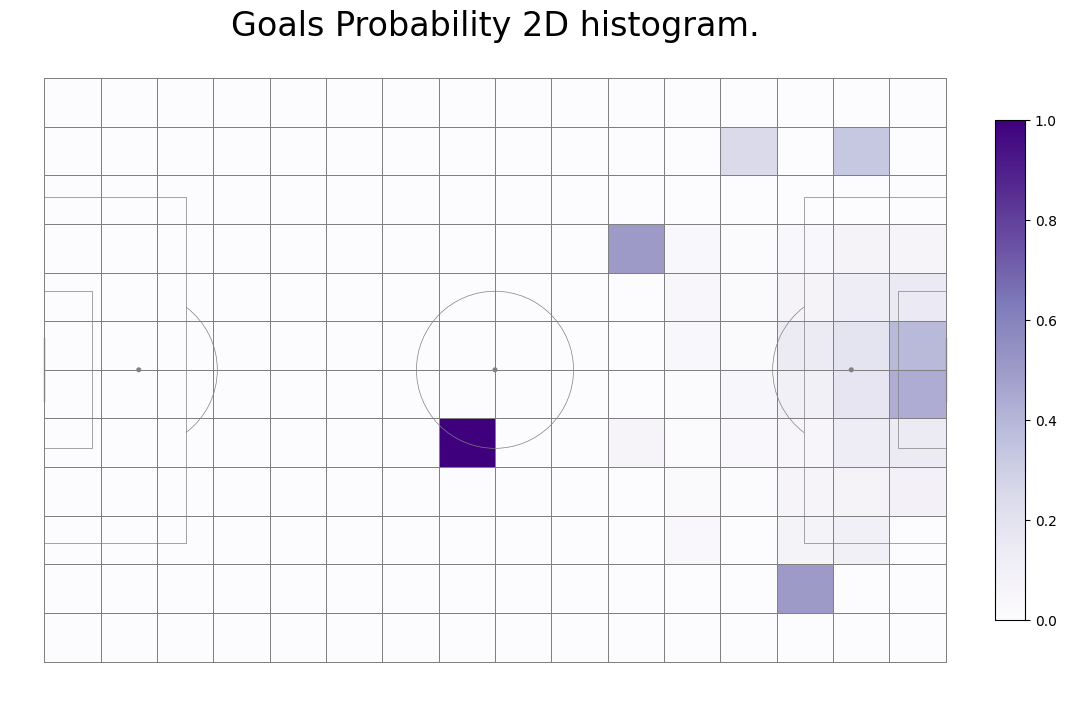

In [122]:
goal_probability = goals_count / shots_count
goal_probability[np.isnan(goal_probability)] = 0
fig, ax = pitch.draw(figsize=(10, 10), tight_layout=True)
goals['statistic'] = goal_probability
pcm = pitch.heatmap(goals, cmap="Purples", edgecolor="grey", ax=ax, linewidth=0.5)

# ADd legend to plot
ax_cbar = fig.add_axes((1, 0.25, 0.03, 0.5))
cbar = plt.colorbar(pcm, cax=ax_cbar)


ax.set_title('Goals Probability 2D histogram.', fontsize=24)
plt.show()

## Transition Matrices

For each of 192 sectors we need to calculate a transition matrix \
A matrix of probabilities going from one zone to another one given \
that the ball was moved.
1. Create another columns in the `move_df` with the bin on the histogram that the event started and ended in.
2. Group the data by starting sector and count stats from each of them.
3. For each step of sectors we calculate the probability of transfering the ball from it to all 192 sectors on the pitch.
4. We do it as the division of events that went to the end sector by all events that started in the starting sectior.
5. We vizualize the transtiion matrix for the sector in the bottom left corner of the pitch.

In [133]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

In [153]:
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        # if ((end_sector[0] - 1) > 12) and ((end_sector[1] - 1) > 16):
        #     print("\n-------------------\n")
        #     print(end_sector[1] - 1, end_sector[0] - 1)
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goals["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goals, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

IndexError: index 12 is out of bounds for axis 0 with size 12

In [162]:
end_sector[1] - 1

12

In [165]:
a = np.zeros((12, 16))

In [168]:
a.shape

(12, 16)